In [3]:
import pandas as pd

In [4]:
from math import sqrt
from ProjectTools import OpenBeds
from ProjectTools.OpenBeds import filterDepth

dry = True

if dry == True:
    wgbs_bed_path = './test_data/ENCSR893RHD_modifications_mm39_sub.bed'
    tab_bed_path = './test_data/CRR008807_TAB_merged.bedGraph.gz.bismark.zero.cov_sub.bed'
    oxbs_bed_path = './test_data/CRD018546.gz_val_1_bismark_bt2_pe.deduplicated.bedGraph.gz.bismark.zero.cov_sub.bed'

    nano_2mod_path = './test_data/prom_R10.4.1_E8.2_WGS_brain_DH_5mC_nonAggregated_sub.bedMethyl'
    nano_3mod_path = './test_data/prom_R10.4.1_E8.2_WGS_brain_0.9.1_mods_sub.bed'
    
    nano_mc_df, nano_hmc_df = map(filterDepth, OpenBeds.get_nanopore_threeMod(nano_3mod_path))
    nano_2mod_df = filterDepth(OpenBeds.get_nanopore_twoMod(nano_2mod_path))
    wgbs_df = filterDepth(OpenBeds.get_wgbs(wgbs_bed_path))
    tab_df = filterDepth(OpenBeds.get_bismark(tab_bed_path, "5hmC"))
    oxbs_df = filterDepth(OpenBeds.get_bismark(oxbs_bed_path, "5mC"))

else:
    wgbs_bed_path = './data/ENCSR893RHD_modifications_mm39.bed'
    tab_bed_path = './data/TAB_data/CRR008807_TAB_merged.bedGraph.gz.bismark.zero.cov'
    oxbs_bed_path = './data/CRR008808_oxBS_remergedRaw.zero.cov_modified.bed'

    nano_2mod_path = './data/prom_R10.4.1_E8.2_WGS_brain_DH_5mC_nonAggregated.bedMethyl'
    nano_3mod_path = './data/prom_R10.4.1_E8.2_WGS_brain_0.9.1_mods.bed'

    wgbs_df = filterDepth(OpenBeds.get_wgbs(wgbs_bed_path))
    tab_df = filterDepth(OpenBeds.get_bismark(tab_bed_path, "5hmC"))
    oxbs_df = filterDepth(OpenBeds.get_bismark(oxbs_bed_path, "5mC"))

    nano_mc_df, nano_hmc_df = map(filterDepth, OpenBeds.get_nanopore_threeMod(nano_3mod_path))
    nano_2mod_df = filterDepth(OpenBeds.get_nanopore_twoMod(nano_2mod_path))

In [5]:
from pybedtools import BedTool

def makeIntersect(df, ref):
    return  BedTool.intersect(BedTool.from_dataframe(df), ref, wb=True).to_dataframe(
        names=[*nano_2mod_df.columns, ".1", ".2", ".3", "feature_name", "feature_type"]).drop(columns=[".1", ".2", ".3"])

def tallyModFeatures(genic_intercept_df): 
    grouped = genic_intercept_df.groupby(["method", "feature_type"])["feature_type"]
    grouped_df_with_counts = pd.DataFrame(grouped.count()).rename(columns={"feature_type" : "count"}).reset_index()
    
    grouped_df_with_counts["method_percentage"] = grouped_df_with_counts["count"] / grouped_df_with_counts.groupby(["method"])["count"].transform("sum")
    return grouped_df_with_counts

# def tallyAll(genic_intercept_df):

ref_features = BedTool('./feature_references/fig4_features.bed')
cgi_features = BedTool('./feature_references/mm39_CGI_features.bed')

In [6]:
union_df = BedTool.intersect(
    BedTool.from_dataframe(
        pd.merge(nano_2mod_df, wgbs_df, "outer", 
            on=["chromosome", "chromStart", "chromEnd"]).drop(columns=[
            "modification_type_x","readCount_x","percentMeth_x","method_x","modification_type_y","readCount_y","percentMeth_y","method_y"]).merge(
            nano_hmc_df, "outer", on=["chromosome", "chromStart", "chromEnd"]).drop(
                columns=["modification_type","readCount","percentMeth","method"]).merge(
            tab_df, "outer", on=["chromosome", "chromStart", "chromEnd"]).drop(
                columns=["modification_type","readCount","percentMeth","method"])),
    ref_features, wb=True
    ).to_dataframe(
        names=["chromosome", "chromStart", "chromEnd", ".1", ".2", ".3", "feature_name", "feature_type"]).drop(
                                                                                                            columns=[".1", ".2", ".3"]
        )
union_df["method"] = "Total"

pd.DataFrame(union_df.groupby(["method", "feature_type"])["feature_type"].count()).rename(columns={"feature_type" : "total_count"}).reset_index()


In [8]:
twoMod_genic_df = makeIntersect(pd.concat([nano_2mod_df, wgbs_df]), ref_features)
mc_genic_df = makeIntersect(pd.concat([nano_mc_df, oxbs_df]), ref_features)
hmc_genic_df = makeIntersect(pd.concat([nano_hmc_df, tab_df]), ref_features)

<Axes: >

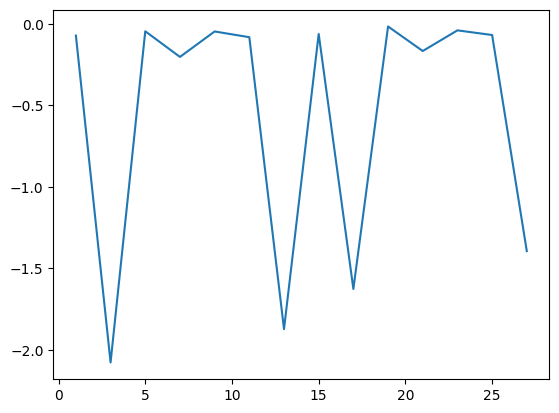

In [80]:
from sklearn import preprocessing
import numpy as np

binariser = preprocessing.Binarizer()
twoMod_genic_df["hasMod"] = binariser.fit_transform(twoMod_genic_df["percentMeth"].to_numpy().reshape((-1, 1)))
df = pd.DataFrame(twoMod_genic_df.groupby(["method", "feature_type", "hasMod"])["feature_name"].count())
df["log2_ratio_cpgs_with_mod"] = np.log2(np.divide(df, df.groupby(["method", "feature_type"]).transform("sum")))
df = df.reset_index()
df.loc[df["hasMod"] == 1.0, "log2_ratio_cpgs_with_mod"].plot()

In [19]:
twoMod_count_df = tallyModFeatures(pd.concat([twoMod_genic_df.loc[twoMod_genic_df["percentMeth"] > 0], union_df]))

mc_count_df = tallyModFeatures(pd.concat([mc_genic_df.loc[mc_genic_df["percentMeth"] > 0], union_df]))
hmc_count_df = tallyModFeatures(pd.concat([hmc_genic_df.loc[hmc_genic_df["percentMeth"] > 0], union_df]))

twoMod_count_df["method"] = pd.Categorical(twoMod_count_df["method"], ["WGBS", "Nanopore 2-state", "Total"])
mc_count_df["method"] = pd.Categorical(mc_count_df["method"], ["oxBS", "Nanopore 5mC", "Total"])
hmc_count_df["method"] = pd.Categorical(hmc_count_df["method"], ["TAB", "Nanopore 5hmC", "Total"])

In [7]:
def groupByFeature(df): 
    df = df.groupby(["feature_name", "feature_type", "method"])["percentMeth"].mean().reset_index() # first group CpGs by feature 
    df = df.groupby(["feature_type", "method"])["percentMeth"].mean().reset_index() # then group features by feature type
    return df 

gene_df = pd.concat([groupByFeature(twoMod_genic_df), groupByFeature(mc_genic_df), groupByFeature(hmc_genic_df)])
# gene_df = gene_df.loc[gene_df["feature_type"] != "Enhancer"] # to get rid of enhancers (reduce CpGs being counted twice)

gene_df["feature_type"] = pd.Categorical(gene_df["feature_type"], ["Promoter", "5UTR", "Exon", "Intron", "3UTR", "Intergenic", "Enhancer"])

In [8]:
twoMod_cgi = makeIntersect(
    pd.concat([nano_2mod_df, wgbs_df]), cgi_features).groupby(
    ["feature_name", "feature_type", "method"])["percentMeth"].mean().reset_index().groupby(
    ["feature_type", "method"])["percentMeth"].mean().reset_index()

mc_cgi = makeIntersect(
    pd.concat([nano_mc_df, oxbs_df]), cgi_features).groupby(
    ["feature_name", "feature_type", "method"])["percentMeth"].mean().reset_index().groupby(
    ["feature_type", "method"])["percentMeth"].mean().reset_index()

hmc_cgi_df = makeIntersect(
    pd.concat([nano_hmc_df, tab_df]), cgi_features).groupby(
    ["feature_name", "feature_type", "method"])["percentMeth"].mean().reset_index().groupby(
    ["feature_type", "method"])["percentMeth"].mean().reset_index()

cgi_df = pd.concat([twoMod_cgi, mc_cgi, hmc_cgi_df])
cgi_df["feature_type"] = pd.Categorical(cgi_df["feature_type"], ["Open sea", "Upstream shelf", "Upstream shore", "CGI", "Downstream shore", "Downstream shelf"])

/tmp/ipykernel_2031072/1472936821.py:39: MatplotlibDeprecationWarning: Passing the loc parameter of __init__() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  plt.figlegend(handles, labels, "upper center", ncols=7, bbox_to_anchor=(0.5, 1.04))


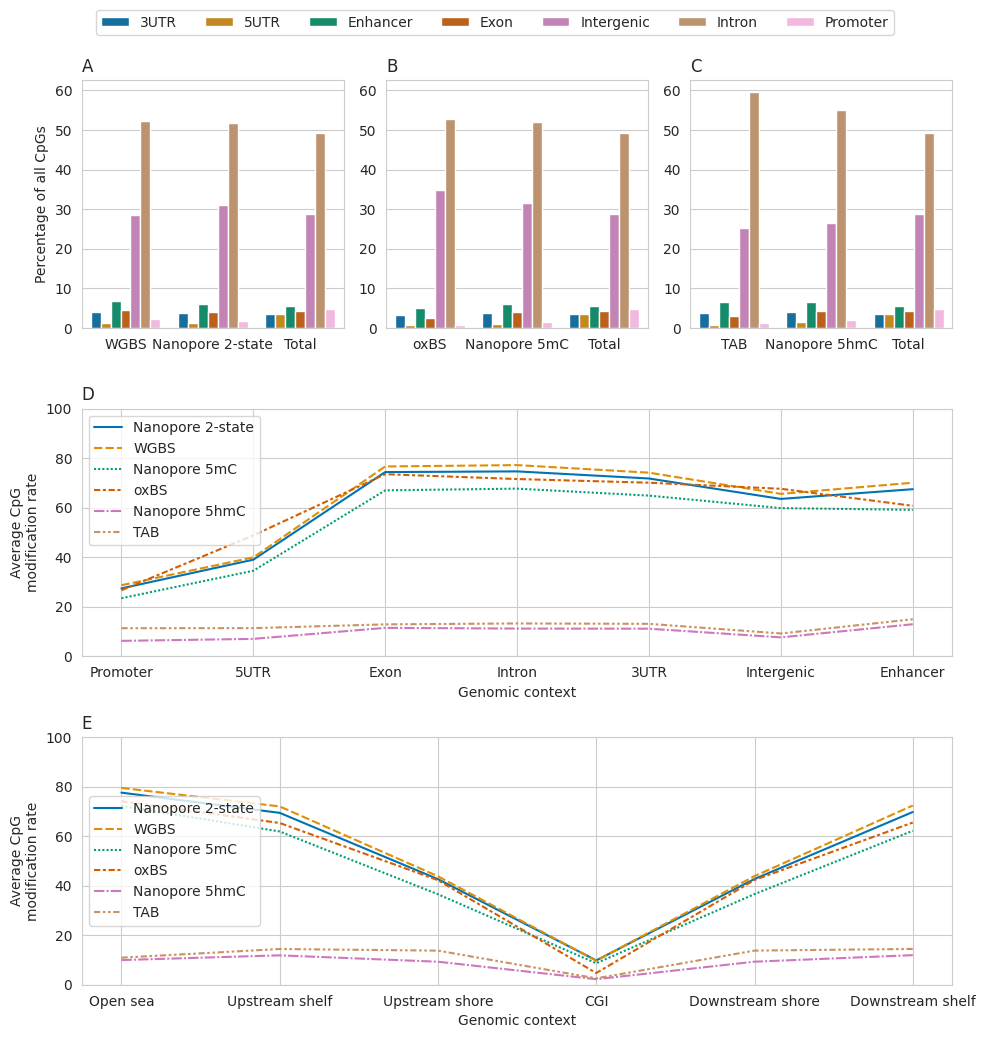

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np

sns.set_style("whitegrid")
sns.set_palette("colorblind")

fig = plt.figure(figsize=(10, 10), dpi=600)
gs = GridSpec(3, 3, fig)

ax1 = fig.add_subplot(gs[0, 0])
sns.barplot(twoMod_count_df, x="method", y="method_percentage", hue="feature_type", ax=ax1)
ax1.set_title("A", loc="left")
ax1.get_legend().remove()
ax1.set_xlabel(None)
ax1.set_ylabel("Percentage of all CpGs")
ax1.set_yticks(np.arange(0, 0.7, 0.1), labels=np.arange(0, 70, 10))

ax2 = fig.add_subplot(gs[0, 1], sharey=ax1)
sns.barplot(mc_count_df, x="method", y="method_percentage", hue="feature_type", ax=ax2)
ax2.set_title("B", loc="left")
ax2.set_ylabel(None)
ax2.get_legend().remove()
ax2.set_xlabel(None)
#ax2.set_ylabel("Percentage of all CpGs")
ax2.set_yticks(np.arange(0, 0.7, 0.1), labels=np.arange(0, 70, 10))

ax3 = fig.add_subplot(gs[0, 2], sharey=ax1)
sns.barplot(hmc_count_df, x="method", y="method_percentage", hue="feature_type", ax=ax3)
ax3.set_title("C", loc="left")
ax3.set_ylabel(None)
ax3.get_legend().remove()
ax3.set_xlabel(None)
#ax3.set_ylabel("Percentage of all CpGs")
ax3.set_yticks(np.arange(0, 0.7, 0.1), labels=np.arange(0, 70, 10))

handles, labels = ax1.get_legend_handles_labels()
plt.figlegend(handles, labels, "upper center", ncols=7, bbox_to_anchor=(0.5, 1.04))

ax4 = fig.add_subplot(gs[1, :])
sns.lineplot(gene_df, x="feature_type", y="percentMeth", hue="method", ax=ax4, style="method")
ax4.set_ylim(0, 100)
ax4.set_xlabel("Genomic context")
ax4.set_ylabel("Average CpG\nmodification rate")
sns.move_legend(ax4, "upper left", title=None)
ax4.set_title("D", loc="left")

ax5 = fig.add_subplot(gs[2, :])
sns.lineplot(cgi_df, x="feature_type", y="percentMeth", hue="method", ax=ax5, style="method")
ax5.set_ylim(0, 100)
ax5.set_xlabel("Genomic context")
ax5.set_ylabel("Average CpG\nmodification rate")
sns.move_legend(ax5, "center left", title=None)
ax5.set_title("E", loc="left")

fig.tight_layout()